# ENSF 519.01 Applied Data Science 
**Final Project - Prediciting Alberta Natural Gas Prices using Machine Learning**

**Due:** Sometime in December


**Team Members:**
James Bews,
Kendal Blais,
Tevin Schmidt,
Peter Schulze,

**Phase I:** Collect, Integrate and Clean data


**Data Collection**

In [1]:
import pandas as pd

# aggregate consumption
cad_data = pd.read_csv('CAD_NatGasSupply_Monthly.csv', thousands=',').rename(columns={'Month': 'Date'}).set_index('Date') # volumes in cubic meters
us_prod_data = pd.read_csv('US_NatGasProd_Monthly.csv').set_index('Date') # volumes in MMcf
us_demand_data = pd.read_csv('US_NatGasDemand_Monthly.csv').set_index('Date').dropna() # volumes in MMcf
price_data = pd.read_csv('US_CAN_NatGas_Prices.csv').set_index('Date') # prices in USD


In [2]:
from bs4 import BeautifulSoup
import requests
from datetime import datetime

storage_stats_url = 'https://www150.statcan.gc.ca/t1/tbl1/en/cv!recreate.action?pid=2510005701&selectedNodeIds=2D2,3D1&checkedLevels=0D1&refPeriods=20160101,20190801&dimensionLayouts=layout2,layout3,layout2,layout2&vectorDisplay=false'

def get_page_html(url):
    return requests.get(url,timeout=10)

storage_stats_html = get_page_html(storage_stats_url).content
storage_stats_html

b'<!DOCTYPE html>\r\n<html class="no-js" lang="en" dir="ltr" xmlns="http://www.w3.org/1999/xhtml">\r\n  <head>\r\n<meta charset="utf-8">\r\n<base href="https://www150.statcan.gc.ca/t1/tbl1/" /><title>\r\n    Add/Remove data - Canadian natural gas storage, Canada and provinces, monthly</title>\r\n <link rel="schema.dcterms" href="http://purl.org/dc/terms/"/>\r\n<meta name="description" content="Natural gas storage opening and closing inventories, injections, withdrawals and adjustments reported in gigajoules and cubic metres, monthly, January 2016 to present." />\r\n<meta name="keywords" content="" />\r\n<meta name="dcterms.title" content="Add/Remove data - Canadian natural gas storage, Canada and provinces, monthly"/>\r\n<meta name="dcterms.language" title="ISO639-2" content="eng" />\r\n<meta name="dcterms.issued" title="W3CDTF" content="2018-04-04" />\r\n<meta name="dcterms.modified" title="W3CDTF" content="2019-11-22" />\r\n<meta name="dcterms.subject" title="gcstc" content="none" />

In [3]:

parser = BeautifulSoup(storage_stats_html, 'html.parser')

column_name_selector = '.pub-table .uom-center.bold'
date_column = list(map(lambda elem: elem.text, parser.select(column_name_selector)))[2:]
date_column = list(map(lambda elem: datetime.strptime(elem, '%B %Y').strftime('%b-%y'), date_column))

column_name_selector = '.pub-table .highlight-row .align-right'
closing_inventory_column = list(map(lambda elem: float(elem.text.replace(',', '')), parser.select(column_name_selector)))

storage_stats_dict = {'Date': date_column, 'CAD Storage Volumes (MMcf)': closing_inventory_column}
storage_stats_df = pd.DataFrame(storage_stats_dict).set_index('Date')
# storage_stats_df contains closing inventory of a given month in cubic meters
storage_stats_df


,CAD Storage Volumes (MMcf)
Date,
Jan-16,22220401.0
Feb-16,20472652.0
Mar-16,21006678.0
Apr-16,21036484.0
May-16,22392448.0
Jun-16,23743852.0
Jul-16,24585440.0
Aug-16,26122336.0
Sep-16,27420813.0


**Data Preparation**

- Canadian demand need to be agregated
- Volumes must be converted to MMcf
- USD must be convetred to CAD


In [4]:
# Aggregate CAD Consumption
cad_data['CAD Natural Gas Consumption (MMcf)'] = cad_data['Residential consumption']+cad_data['Commercial consumption']+cad_data['Industrial consumption']
cad_data = cad_data.rename(columns={'Marketable production': 'CAD Natural Gas Production (MMcf)'})
cad_data = cad_data.drop(['Gross withdrawals','Imports','Residential consumption', 'Industrial consumption', 'Commercial consumption', 'Exports', 'Opening inventory', 'Closing inventory', 'Inventory change'], axis=1)
cad_data

,CAD Natural Gas Production (MMcf),CAD Natural Gas Consumption (MMcf)
Date,,
Jan-16,14289542.7,11065298.7
Feb-16,13607932.1,9863883.1
Mar-16,14421808.5,9690121.5
Apr-16,13104382.7,7982794.7
May-16,14139484.9,6616912.9
Jun-16,13477340.2,7354024.2
Jul-16,13928637.2,7725783.2
Aug-16,14248386.5,7710188.5
Sep-16,13546045.8,6258890.8


In [5]:
# Convert volumes 

# cubic meters to cubic feet -> 35.3146667
# divide by 1 million to convert cubic feet to MMcf
# times by 1000 because the Canadian data was given to us with a scale of 1000 
cm_to_mmcf = 35.3146667 / 1000000 * 1000
# First convert storage_stats_df from cubic meters to MMcf
conv_cad_storage = storage_stats_df['CAD Storage Volumes (MMcf)'].apply(lambda x: x * cm_to_mmcf)

# Second convert price_data from USD to CAD
conv_price_data = pd.DataFrame()
conv_price_data['AECO (CAD/MMBtu)'] = price_data.apply(
    lambda x: x['AECO (USD/MMBtu)'] / x['CADUSD'], axis=1)
conv_price_data['AECO (CAD/GJ)'] = conv_price_data.apply(
    lambda x: round(x['AECO (CAD/MMBtu)'] * 1.055056, 2), axis=1)
conv_price_data = conv_price_data.drop(['AECO (CAD/MMBtu)'], axis=1)
# Third convert cad_data from cubic meters to MMcf
conv_cad_data = cad_data.apply(lambda x: x * cm_to_mmcf)
conv_price_data

,AECO (CAD/GJ)
Date,
Jan-16,2.51
Feb-16,1.89
Mar-16,1.38
Apr-16,1.18
May-16,1.42
Jun-16,2.11
Jul-16,2.45
Aug-16,2.50
Sep-16,2.74


**Data Exploration**

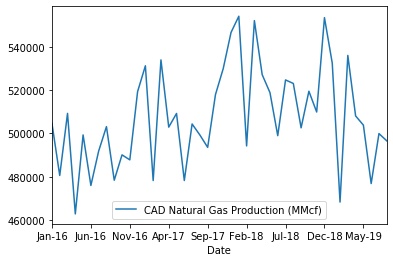

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

#CAD Production
ax = plt.gca()
conv_cad_data.plot(kind='line', y='CAD Natural Gas Production (MMcf)', ax=ax)
plt.show()

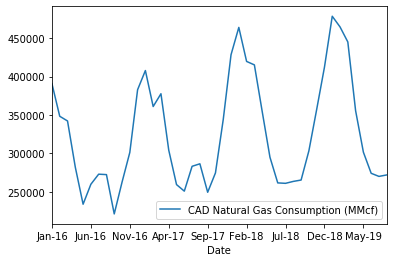

In [7]:
#CAD Consumption
ax = plt.gca()
conv_cad_data.plot(kind='line', y='CAD Natural Gas Consumption (MMcf)', ax=ax)
plt.show()

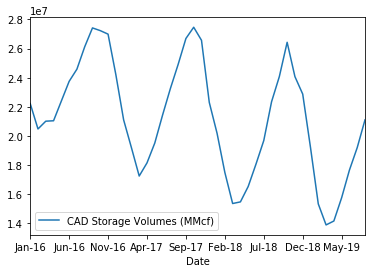

In [8]:
# CAD Storage Volumes
ax = plt.gca()
storage_stats_df.plot(kind='line', y='CAD Storage Volumes (MMcf)', ax=ax)
plt.show()

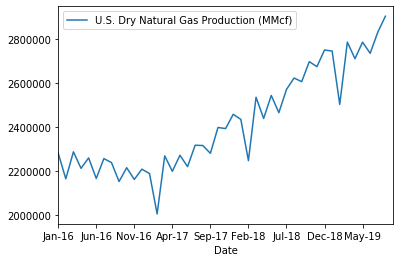

In [9]:
#US Production
ax = plt.gca()
us_prod_data.plot(kind='line', y='U.S. Dry Natural Gas Production (MMcf)', ax=ax)
plt.show()

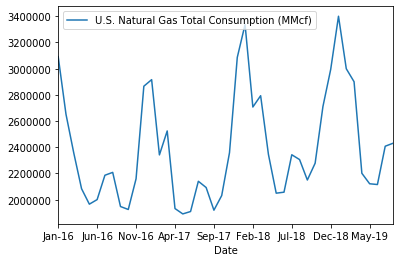

In [10]:
#US Demand
ax = plt.gca()
us_demand_data.plot(kind='line', y='U.S. Natural Gas Total Consumption (MMcf)', ax=ax)
plt.show()

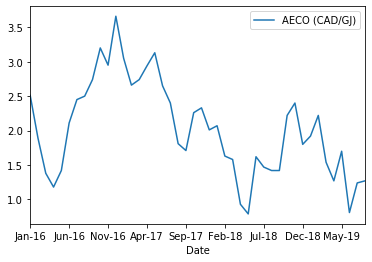

In [11]:
# AECO Nat Gas Pricing
ax = plt.gca()
conv_price_data.plot(kind='line', y='AECO (CAD/GJ)', ax=ax)
plt.show()

In [12]:
#Merging all data into one dataframe

total_us_data = us_prod_data.merge(us_demand_data, left_index=True, right_on='Date')
total_cad_data = conv_cad_data.merge(conv_cad_storage, left_index=True, right_on='Date')

total_data = total_us_data.merge(total_cad_data, left_index=True, right_on='Date')
total_data = total_data.apply(lambda x: round(x.apply(lambda y: int(y))))
features = total_data.merge(conv_price_data, left_index=True, right_on='Date')
features = features.reset_index()
features['Date'] = pd.to_datetime(features.Date, format='%b-%y')
features = features.set_index('Date')
features

,U.S. Dry Natural Gas Production (MMcf),U.S. Natural Gas Total Consumption (MMcf),CAD Natural Gas Production (MMcf),CAD Natural Gas Consumption (MMcf),CAD Storage Volumes (MMcf),AECO (CAD/GJ)
Date,,,,,,
2016-01-01,2280340,3091695,504630,390767,784706,2.51
2016-02-01,2163435,2652260,480559,348339,722984,1.89
2016-03-01,2286521,2356298,509301,342203,741843,1.38
2016-04-01,2211218,2083848,462776,281909,742896,1.18
2016-05-01,2258898,1965799,499331,233674,790781,1.42
2016-06-01,2165089,2000656,475947,259704,838506,2.11
2016-07-01,2255564,2186616,491885,272833,868226,2.45
2016-08-01,2237678,2208375,503177,272282,922501,2.50
2016-09-01,2151150,1947752,478374,221030,968356,2.74


**Data Prediction**

**Testing Causality (Granger's Causality Test)**

If the p-value between 2 variables X and Y is less than 0.05, then X causes Y

In [20]:
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests

def grangers_test(data, variables, test='ssr_chi2test', maxlag=12, verbose=False):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for column in df.columns:
        for row in df.index:
            test_result = grangercausalitytests(data[[row,column]], maxlag=maxlag, verbose=verbose)
            p_values = [round(test_result[i+1][0][test][1], 4) for i in range(maxlag)]
            
            min_p_value = np.min(p_values)
            df.loc[row,column] = min_p_value
            
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_test(features, variables=features.columns)

,U.S. Dry Natural Gas Production (MMcf)_x,U.S. Natural Gas Total Consumption (MMcf)_x,CAD Natural Gas Production (MMcf)_x,CAD Natural Gas Consumption (MMcf)_x,CAD Storage Volumes (MMcf)_x,AECO (CAD/GJ)_x
U.S. Dry Natural Gas Production (MMcf)_y,1.0,0.0,0.0000,0.0,0.0,0.0
U.S. Natural Gas Total Consumption (MMcf)_y,0.0,1.0,0.0000,0.0,0.0,0.0
CAD Natural Gas Production (MMcf)_y,0.0,0.0,1.0000,0.0,0.0,0.0
CAD Natural Gas Consumption (MMcf)_y,0.0,0.0,0.0000,1.0,0.0,0.0
CAD Storage Volumes (MMcf)_y,0.0,0.0,0.0000,0.0,1.0,0.0
AECO (CAD/GJ)_y,0.0,0.0,0.0004,0.0,0.0,1.0


In [21]:
n_obs = 10
X_train, X_test = features[0:-n_obs], features[-n_obs:]

print(X_train.shape)
print(X_test.shape)

(34, 6)
(10, 6)


In [22]:
from statsmodels.tsa.stattools import adfuller
from scipy import stats

def adf_test(series, signif=0.05, name='', verbose=False):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1],4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length=6): return str(val).ljust(length)
    
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Significance Level    = {signif}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")
    return output
          
def test_stationality(df):
    lags = []
    for name, column in df.iteritems():
          output = adf_test(column, name=column.name)
          lags.append(output['n_lags'])
          print('\n')
    lags = np.array(lags)
    return stats.mode(lags)[0][0]

        
lag = test_stationality(X_train)
print('Lag -> ', lag)

    Augmented Dickey-Fuller Test on "U.S. Dry Natural Gas Production (MMcf)" 
    -----------------------------------------------
 Significance Level    = 0.05
 No. Lags Chosen       = 2
 => P-Value = 0.9953. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "U.S. Natural Gas Total Consumption (MMcf)" 
    -----------------------------------------------
 Significance Level    = 0.05
 No. Lags Chosen       = 1
 => P-Value = 0.0098. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "CAD Natural Gas Production (MMcf)" 
    -----------------------------------------------
 Significance Level    = 0.05
 No. Lags Chosen       = 0
 => P-Value = 0.0002. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "CAD Natural Gas Consumption (MMcf)" 
    -----------------------------------------------
 Significance Level    = 0.05
 No. Lags Chosen       = 10
 => 

    Augmented Dickey-Fuller Test on "U.S. Dry Natural Gas Production (MMcf)" 
    -----------------------------------------------
 Significance Level    = 0.05
 No. Lags Chosen       = 10
 => P-Value = 0.5927. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "U.S. Natural Gas Total Consumption (MMcf)" 
    -----------------------------------------------
 Significance Level    = 0.05
 No. Lags Chosen       = 10
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "CAD Natural Gas Production (MMcf)" 
    -----------------------------------------------
 Significance Level    = 0.05
 No. Lags Chosen       = 10
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "CAD Natural Gas Consumption (MMcf)" 
    -----------------------------------------------
 Significance Level    = 0.05
 No. Lags Chosen       = 10
 => P-V

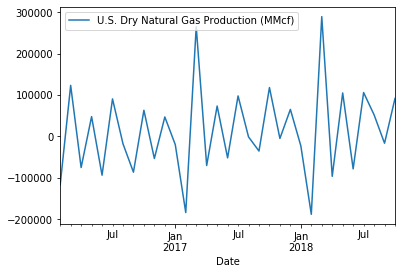

In [26]:
#First Difference

differenced = X_train.diff().dropna()
lag = test_stationality(differenced)
print('Lag -> ', lag)
ax = plt.gca()
differenced.plot(kind='line', y='U.S. Dry Natural Gas Production (MMcf)', ax=ax)
plt.show()

    Augmented Dickey-Fuller Test on "U.S. Dry Natural Gas Production (MMcf)" 
    -----------------------------------------------
 Significance Level    = 0.05
 No. Lags Chosen       = 10
 => P-Value = 0.0377. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "U.S. Natural Gas Total Consumption (MMcf)" 
    -----------------------------------------------
 Significance Level    = 0.05
 No. Lags Chosen       = 10
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "CAD Natural Gas Production (MMcf)" 
    -----------------------------------------------
 Significance Level    = 0.05
 No. Lags Chosen       = 10
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "CAD Natural Gas Consumption (MMcf)" 
    -----------------------------------------------
 Significance Level    = 0.05
 No. Lags Chosen       = 10
 => P-Value = 0.0. Rejecting 

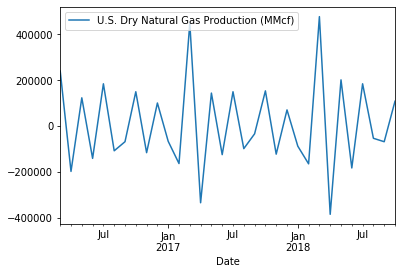

In [27]:
differenced = differenced.diff().dropna()
test_stationality(differenced)
print('Lag -> ', lag)
ax = plt.gca()
differenced.plot(kind='line', y='U.S. Dry Natural Gas Production (MMcf)', ax=ax)
plt.show()

In [33]:
from statsmodels.tsa.api import VAR

model = VAR(differenced)
model_fitted = model.fit(lag)

c:\users\james\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [38]:
forecast_input = differenced.values[-lag:]
fc = model_fitted.forecast(y=forecast_input, steps=n_obs)
df_forecast = pd.DataFrame(fc, index=features.index[-n_obs:], columns=features.columns + '_2d')
df_forecast

,U.S. Dry Natural Gas Production (MMcf)_2d,U.S. Natural Gas Total Consumption (MMcf)_2d,CAD Natural Gas Production (MMcf)_2d,CAD Natural Gas Consumption (MMcf)_2d,CAD Storage Volumes (MMcf)_2d,AECO (CAD/GJ)_2d
Date,,,,,,
2018-11-01,-50458.140341,2.003267e+05,3697.008798,23275.356997,-100622.525732,-1.128418
2018-12-01,-46381.941225,3.191766e+05,-17116.665156,17134.393073,-120672.704097,0.541821
2019-01-01,73712.943050,3.175112e+04,43515.994159,-9318.033189,25481.139235,-0.884652
2019-02-01,-334365.746243,-1.446063e+06,-133065.657455,-115125.130016,-990.958307,-0.255455
2019-03-01,528247.202884,8.179699e+05,147997.764634,42272.806575,-5482.347146,1.456671
2019-04-01,-326343.599019,-5.028294e+05,-85158.067422,-70100.665530,82285.677908,-1.167441
2019-05-01,177511.380670,9.787789e+04,19381.766517,-115.840226,79292.975079,0.757067
2019-06-01,-151101.907922,3.110904e+05,-26275.596750,50534.994236,-6198.278322,0.571171
2019-07-01,92842.932732,2.530296e+05,46141.826846,9967.659343,59823.122591,-0.537663


In [39]:
# Undifference

columns = X_train.columns
for column in columns:
    df_forecast[str(column) + '_ld'] = (X_train[column].iloc[-1] - X_train[column].iloc[-2]) + df_forecast[str(column) + '_2d'].cumsum()
    # Roll back 1st diff 
    df_forecast[str(column) + '_fc'] = X_train[column].iloc[-1] + df_forecast[str(column) + '_ld'].cumsum()

df_forecast.loc[:,['U.S. Dry Natural Gas Production (MMcf)_fc', 'U.S. Natural Gas Total Consumption (MMcf)_fc', 'CAD Natural Gas Production (MMcf)_fc', 'CAD Natural Gas Consumption (MMcf)_fc', 'CAD Storage Volumes (MMcf)_fc', 'AECO (CAD/GJ)_fc']]


,U.S. Dry Natural Gas Production (MMcf)_fc,U.S. Natural Gas Total Consumption (MMcf)_fc,CAD Natural Gas Production (MMcf)_fc,CAD Natural Gas Consumption (MMcf)_fc,CAD Storage Volumes (MMcf)_fc,AECO (CAD/GJ)_fc
Date,,,,,,
2018-11-01,2.739114e+06,2.607211e+06,540184.008798,364703.356997,915903.474268,1.891582
2018-12-01,2.733808e+06,3.255045e+06,543690.352440,443229.107067,777724.244439,2.104985
2019-01-01,2.802215e+06,3.934631e+06,590712.690242,512436.823948,665026.153845,1.433735
2019-02-01,2.536256e+06,3.168153e+06,504669.370588,466519.410812,551337.104945,0.507031
2019-03-01,2.798544e+06,3.219645e+06,566623.815569,462874.804252,432165.708898,1.036997
2019-04-01,2.734489e+06,2.768308e+06,543420.193128,389129.532161,395279.990760,0.399523
2019-05-01,2.847945e+06,2.414849e+06,539598.337203,315268.419845,437687.247700,0.519116
2019-06-01,2.810299e+06,2.372480e+06,509500.884528,291942.301764,473896.226318,1.209880
2019-07-01,2.865496e+06,2.583140e+06,525545.258700,278583.843026,569928.327527,1.362980


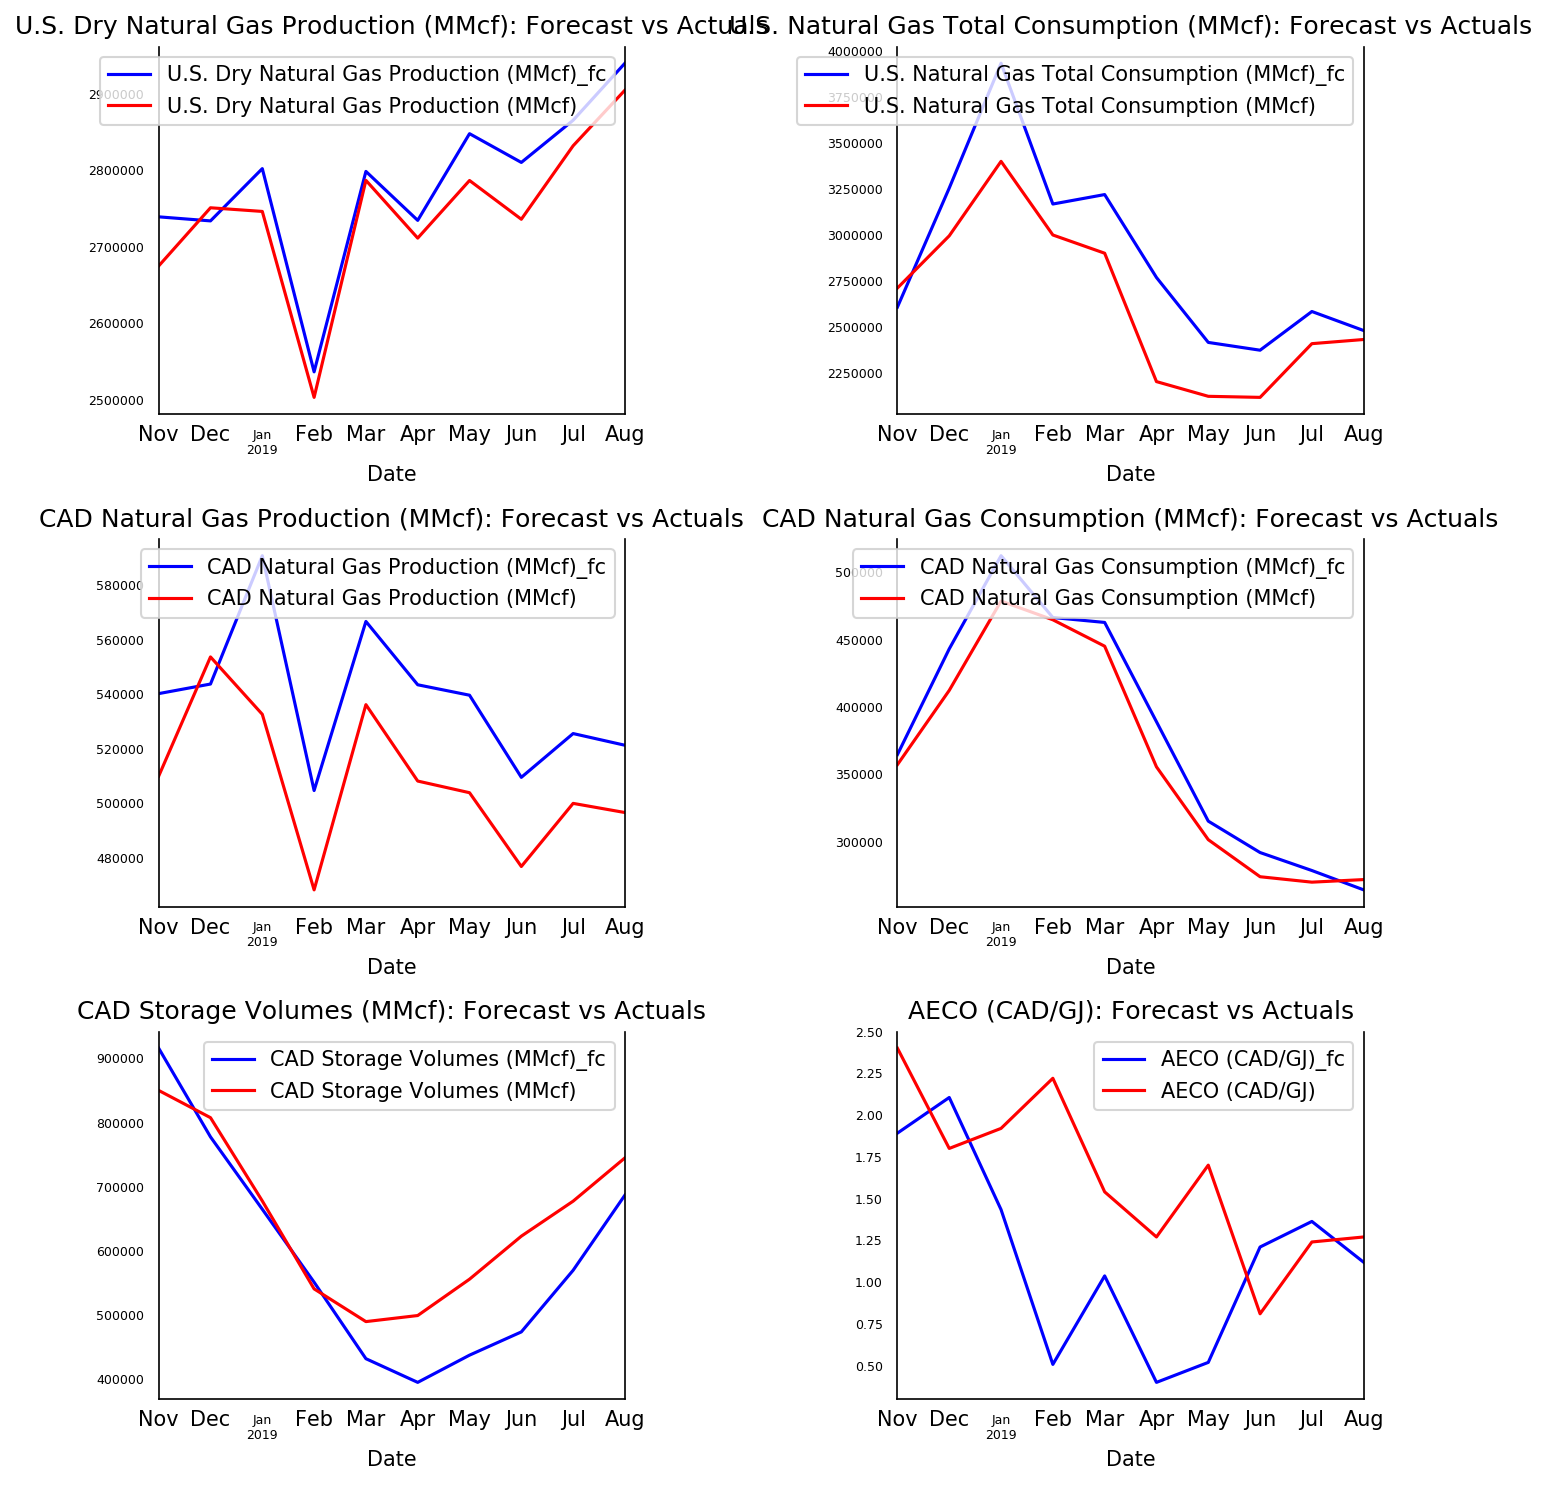

In [42]:
fig, axes = plt.subplots(nrows=int(len(features.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(features.columns, axes.flatten())):
    df_forecast[col+'_fc'].plot(legend=True, color='b', ax=ax).autoscale(axis='x',tight=True)
    X_test[col][-n_obs:].plot(legend=True, color='r', ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();